<a href="https://colab.research.google.com/github/Salmak02/RetVecGP/blob/main/RetVec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install retvec
!pip install tensorflow
try:
    import tensorflow_text
except ImportError:
    !pip install tensorflow-text


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 36.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from retvec.tf import RETVecTokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
dataSet = pd.read_csv('Phishing_Email.csv')
email = dataSet['Email Text']

# num of phishing and safe at all data before removing sum phishing
phising = (dataSet['Email Type'] == "Phishing Email").sum()
safe = (dataSet['Email Type'] == "Safe Email").sum()
print(f"phising precentage: {phising}")
print(f"safe precentage: {safe}")

NUM_CLASSES = 2

# Remove 2000 rows (almost 50% of phishing) 10% of total dataset
value_to_remove = 'Phishing Email' # phishing
num_rows_to_remove = 2000
# Filter the dataset based on the 'Email Type' column
phishingSet = dataSet[dataSet['Email Type'] == value_to_remove]
# Remove the first num_rows_to_remove rows
phishingSet = phishingSet.iloc[num_rows_to_remove:].reset_index(drop=True)
safeSet=dataSet[dataSet['Email Type'] == 'Safe Email']
# Concatenate vertically (along rows)
result = pd.concat([phishingSet, safeSet], ignore_index=True)
result = result.sample(frac=1)

x_train, x_test, y_train, y_test = train_test_split(result['Email Text'], result['Email Type'],test_size=0.2, random_state=0, shuffle=True)

test = pd.DataFrame()
test['Email Text']= x_test
# Create two new columns
test['Email Type'] = y_test
# Remove 1000 rows (almost 50% of phishing) 10% of total dataset
value_to_remove = 'Safe Email'
num_rows_to_remove = 1000
# Filter the dataset based on the 'Email Type' column
SafeSet = test[test['Email Type'] == value_to_remove]
# Remove the first num_rows_to_remove rows
SafeSet = SafeSet.iloc[num_rows_to_remove:].reset_index(drop=True)
PhishingSet = test[test['Email Type'] == 'Phishing Email']

# num of phishing and safe at all data before removing sum phishing
phising = (test['Email Type'] == 'Phishing Email').sum()
safe = (test['Email Type'] == 'Safe Email').sum()
print(f"phising precentage: {phising}")
print(f"safe precentage: {safe}")

# Concatenate vertically (along rows)
result = pd.concat([SafeSet , PhishingSet], ignore_index=True)
result = result.sample(frac=1)



# Now y_train_df has two columns 'label_0' and 'label_1' where 'label_0' contains 1 for 0 values and 'label_1' contains 1 for 1 values
x_train = x_train.astype(str)
x_train = tf.constant(x_train, dtype=tf.string)
le = LabelEncoder()
y_train = le.fit_transform(y_train)

x_test=result['Email Text']
y_test=result['Email Type']
x_test = x_test.astype(str)
x_test = tf.constant(x_test, dtype=tf.string)
y_test = le.transform(y_test)

phising = (y_test == 0).sum()
safe = (y_test == 1).sum()
print(f"phising precentage at Testing: {phising}")
print(f"safe precentage at Testing: {safe}")



# Train and Test Dataframe Split and Save
trainDataframe = pd.DataFrame()
trainDataframe['Email Text']=x_train
# Create two new columns
trainDataframe['Phishing Email']=(y_train == 0).astype(int)
trainDataframe['Safe Email']=(y_train == 1).astype(int)
trainDataframe.to_csv('TrainRetVec.csv', index=False)

testDataframe = pd.DataFrame()
testDataframe['Email Text']= x_test
# Create two new columns
testDataframe['Phishing Email']=(y_test== 0).astype(int)
testDataframe['Safe Email']=(y_test == 1).astype(int)
testDataframe.to_csv('TestRetVec.csv', index=False)
print(testDataframe['Safe Email'])
print(testDataframe['Phishing Email'])

# 1 Safe & 0 Phishing

phising precentage: 7328
safe precentage: 11322
phising precentage: 1048
safe precentage: 2282
phising precentage at Testing: 1048
safe precentage at Testing: 1282
0       1
1       1
2       0
3       0
4       1
       ..
2325    1
2326    1
2327    1
2328    1
2329    0
Name: Safe Email, Length: 2330, dtype: int64
0       0
1       0
2       1
3       1
4       0
       ..
2325    0
2326    0
2327    0
2328    0
2329    1
Name: Phishing Email, Length: 2330, dtype: int64


In [ ]:
# Define the input layer, which accepts raw strings
inputs = layers.Input(shape=(1, ), name="Emails tokens" , dtype = tf.string )

# Add the RETVec Tokenizer layer using the RETVec embedding model -- that's it!
x = RETVecTokenizer(model='retvec-v1')(inputs)
# save the model
#x = RETVecTokenizer(model='retvec-v1', use_tf_lite_compatible_ops=True)(inputs)
# Create your model like normal
# e.g. a simple LSTM model for classification with NUM_CLASSES classes
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

645/645 [==============================] - 0s 0us/step


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Emails tokens (InputLayer)  [(None, 1)]               0         
                                                                 
 ret_vec_tokenizer (RETVecT  (None, 128, 256)          230144    
 okenizer)                                                       
                                                                 
 bidirectional (Bidirection  (None, 128, 128)          164352    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                             

In [ ]:
# save the model
# save_path = "./demo_models/tf_lite_retvec"
# model.save(save_path)
# compile and train the model like usual
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
checkpoint_filepath = 'best_model_weights.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',  # Monitor validation accuracy
    mode='max',  # Choose 'max' to save the best weights
    save_best_only=True  # Save only the best weights
)

train_data=pd.read_csv('TrainRetVec.csv')
x_train, x_test, y_train, y_test = train_test_split(train_data['Email Text'],train_data[['Phishing Email','Safe Email']],test_size=0.4, random_state=0, shuffle=True)
batch_size = 256
epochs = 25

# Initialize SGD with Momentum lr is learning rate
sgd = SGD(lr=0.0001, momentum=0.8, nesterov=True)
model.compile(optimizer=sgd,  loss='binary_crossentropy', metrics=['acc'])
print("x_train", x_train.shape)
print("x_test", x_test.shape)
print("y_train", y_train.shape)
print("y_test", y_test.shape)
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(x_test, y_test) , callbacks=[model_checkpoint_callback])# callbacks

x_train (7992,)
x_test (5328,)
y_train (7992, 2)
y_test (5328, 2)
Epoch 1/25
32/32 [==============================] - ETA: 0s - loss: 0.2107 - acc: 0.9115

32/32 [==============================] - 109s 3s/step - loss: 0.2107 - acc: 0.9115 - val_loss: 0.2562 - val_acc: 0.8838
Epoch 2/25
32/32 [==============================] - ETA: 0s - loss: 0.2020 - acc: 0.9237

32/32 [==============================] - 113s 4s/step - loss: 0.2020 - acc: 0.9237 - val_loss: 0.2895 - val_acc: 0.8709
Epoch 3/25
32/32 [==============================] - ETA: 0s - loss: 0.1902 - acc: 0.9217

32/32 [==============================] - 113s 4s/step - loss: 0.1902 - acc: 0.9217 - val_loss: 0.2027 - val_acc: 0.9157
Epoch 4/25
32/32 [==============================] - ETA: 0s - loss: 0.2514 - acc: 0.9005

32/32 [==============================] - 111s 3s/step - loss: 0.2514 - acc: 0.9005 - val_loss: 0.2140 - val_acc: 0.9129
Epoch 5/25
32/32 [==============================] - ETA: 0s - loss: 0.1762 - acc: 0.9254

32/32 [==============================] - 109s 3s/step - loss: 0.1762 - acc: 0.9254 - val_loss: 0.1987 - val_acc: 0.9234
Epoch 6/25
32/32 [==============================] - ETA: 0s - loss: 0.1668 - acc: 0.9317

32/32 [==============================] - 111s 4s/step - loss: 0.1668 - acc: 0.9317 - val_loss: 0.2331 - val_acc: 0.9063
Epoch 7/25
32/32 [==============================] - ETA: 0s - loss: 0.2178 - acc: 0.9198

32/32 [==============================] - 114s 4s/step - loss: 0.2178 - acc: 0.9198 - val_loss: 0.2780 - val_acc: 0.8806
Epoch 8/25
32/32 [==============================] - ETA: 0s - loss: 0.1518 - acc: 0.9402

32/32 [==============================] - 111s 4s/step - loss: 0.1518 - acc: 0.9402 - val_loss: 0.2590 - val_acc: 0.8960
Epoch 9/25
32/32 [==============================] - ETA: 0s - loss: 0.2018 - acc: 0.9203

32/32 [==============================] - 109s 3s/step - loss: 0.2018 - acc: 0.9203 - val_loss: 0.2159 - val_acc: 0.9114
Epoch 10/25
32/32 [==============================] - ETA: 0s - loss: 0.2239 - acc: 0.9117

32/32 [==============================] - 111s 4s/step - loss: 0.2239 - acc: 0.9117 - val_loss: 0.2432 - val_acc: 0.9090
Epoch 11/25
32/32 [==============================] - ETA: 0s - loss: 0.1731 - acc: 0.9314

32/32 [==============================] - 111s 3s/step - loss: 0.1731 - acc: 0.9314 - val_loss: 0.2683 - val_acc: 0.8928
Epoch 12/25
32/32 [==============================] - ETA: 0s - loss: 0.1240 - acc: 0.9503

32/32 [==============================] - 113s 4s/step - loss: 0.1240 - acc: 0.9503 - val_loss: 0.2668 - val_acc: 0.8919
Epoch 13/25
32/32 [==============================] - ETA: 0s - loss: 0.2111 - acc: 0.9153

32/32 [==============================] - 114s 4s/step - loss: 0.2111 - acc: 0.9153 - val_loss: 0.2510 - val_acc: 0.8932
Epoch 14/25
32/32 [==============================] - ETA: 0s - loss: 0.1214 - acc: 0.9521

32/32 [==============================] - 112s 4s/step - loss: 0.1214 - acc: 0.9521 - val_loss: 0.3452 - val_acc: 0.8726
Epoch 15/25
32/32 [==============================] - ETA: 0s - loss: 0.1046 - acc: 0.9568

32/32 [==============================] - 112s 4s/step - loss: 0.1046 - acc: 0.9568 - val_loss: 0.2148 - val_acc: 0.9180
Epoch 16/25
32/32 [==============================] - ETA: 0s - loss: 0.1165 - acc: 0.9508

32/32 [==============================] - 110s 3s/step - loss: 0.1165 - acc: 0.9508 - val_loss: 0.1825 - val_acc: 0.9304
Epoch 17/25
32/32 [==============================] - ETA: 0s - loss: 0.1292 - acc: 0.9462

32/32 [==============================] - 110s 3s/step - loss: 0.1292 - acc: 0.9462 - val_loss: 0.2788 - val_acc: 0.8906
Epoch 18/25
32/32 [==============================] - ETA: 0s - loss: 0.1068 - acc: 0.9543

32/32 [==============================] - 112s 4s/step - loss: 0.1068 - acc: 0.9543 - val_loss: 0.2585 - val_acc: 0.9018
Epoch 19/25
32/32 [==============================] - ETA: 0s - loss: 0.1162 - acc: 0.9540

32/32 [==============================] - 115s 4s/step - loss: 0.1162 - acc: 0.9540 - val_loss: 0.7772 - val_acc: 0.7873
Epoch 20/25
32/32 [==============================] - ETA: 0s - loss: 0.1456 - acc: 0.9416

32/32 [==============================] - 112s 4s/step - loss: 0.1456 - acc: 0.9416 - val_loss: 0.1800 - val_acc: 0.9309
Epoch 21/25
32/32 [==============================] - ETA: 0s - loss: 0.1264 - acc: 0.9489

32/32 [==============================] - 110s 3s/step - loss: 0.1264 - acc: 0.9489 - val_loss: 0.2359 - val_acc: 0.8930
Epoch 22/25
32/32 [==============================] - ETA: 0s - loss: 0.1057 - acc: 0.9545

32/32 [==============================] - 112s 4s/step - loss: 0.1057 - acc: 0.9545 - val_loss: 0.1699 - val_acc: 0.9277
Epoch 23/25
32/32 [==============================] - ETA: 0s - loss: 0.0965 - acc: 0.9597

32/32 [==============================] - 109s 3s/step - loss: 0.0965 - acc: 0.9597 - val_loss: 0.6102 - val_acc: 0.8191
Epoch 24/25
32/32 [==============================] - ETA: 0s - loss: 0.1572 - acc: 0.9368

32/32 [==============================] - 112s 4s/step - loss: 0.1572 - acc: 0.9368 - val_loss: 0.3678 - val_acc: 0.8669
Epoch 25/25
32/32 [==============================] - ETA: 0s - loss: 0.0965 - acc: 0.9603

32/32 [==============================] - 113s 4s/step - loss: 0.0965 - acc: 0.9603 - val_loss: 0.1968 - val_acc: 0.9219


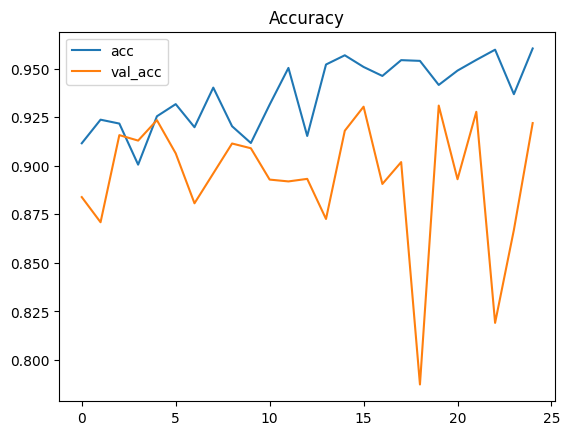

In [ ]:
# visualize the training curves
!pip install matplotlib
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title(f'Accuracy')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_curve, auc
test_data=pd.read_csv('TestRetVec.csv')
print(test_data['Phishing Email'])
print(test_data['Safe Email'])
y_pred = model.predict(test_data['Email Text'])
# Convert predictions back to label encoding
y_pred_label = np.argmax(y_pred, axis=1)
print(y_pred_label)

# Convert true labels back to label encoding
y_test_label = np.column_stack((test_data['Phishing Email'], test_data['Safe Email']))
print("2D Array:")
print(y_test_label)
y_test_label = np.argmax(y_test_label, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print("Accuracy:", accuracy)
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_label, y_pred_label)
# Calculate AUC-PR
auc_pr = auc(recall, precision)
print("AUC-PR:", auc_pr)

0       0
1       0
2       1
3       1
4       0
       ..
2325    0
2326    0
2327    0
2328    0
2329    1
Name: Phishing Email, Length: 2330, dtype: int64
0       1
1       1
2       0
3       0
4       1
       ..
2325    1
2326    1
2327    1
2328    1
2329    0
Name: Safe Email, Length: 2330, dtype: int64
73/73 [==============================] - 23s 285ms/step
[1 1 0 ... 1 1 0]
2D Array:
[[0 1]
 [0 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [1 0]]
Accuracy: 0.9047210300429185
AUC-PR: 0.9283344150371468


In [ ]:
model.save_weights(checkpoint_filepath)
print(f"Model weights saved to {checkpoint_filepath}")
# # Create a new model instance (assuming you've defined your model architecture)
# mod = build_model()

# # Restore the weights
model.load_weights(checkpoint_filepath)
# checks if same test is still working
test_data=pd.read_csv('TestRetVec.csv')
print(test_data['Phishing Email'])
print(test_data['Safe Email'])
y_pred = model.predict(test_data['Email Text'])
# Convert predictions back to label encoding
y_pred_label = np.argmax(y_pred, axis=1)
print(y_pred_label)

# Convert true labels back to label encoding
y_test_label = np.column_stack((test_data['Phishing Email'], test_data['Safe Email']))
print("2D Array:")
print(y_test_label)
y_test_label = np.argmax(y_test_label, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_label, y_pred_label)
print("Accuracy:", accuracy)
# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test_label, y_pred_label)
# Calculate AUC-PR
auc_pr = auc(recall, precision)

Model weights saved to best_model_weights.h5
0       0
1       0
2       1
3       1
4       0
       ..
2325    0
2326    0
2327    0
2328    0
2329    1
Name: Phishing Email, Length: 2330, dtype: int64
0       1
1       1
2       0
3       0
4       1
       ..
2325    1
2326    1
2327    1
2328    1
2329    0
Name: Safe Email, Length: 2330, dtype: int64
73/73 [==============================] - 21s 293ms/step
[1 1 0 ... 1 1 0]
2D Array:
[[0 1]
 [0 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [1 0]]
Accuracy: 0.9047210300429185


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
